# Cross Validation, Model selection, Evaluation on test data (Unseen data), and Inference on similar pairs of Emails, with TSNE 2D Visualizations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random
import os
from scipy.sparse import load_npz
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, reciprocal, randint
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')


In [3]:
# for Reproducibility 
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)


Visualization of high dimensional (5000 features Sparse Matrix) into 2 D PCA , with variance ratio explained

Original train shape: (26882, 5000)
Original test shape: (6721, 5000)

PC1: 2.61% | PC2: 2.13% | Total: 4.74%


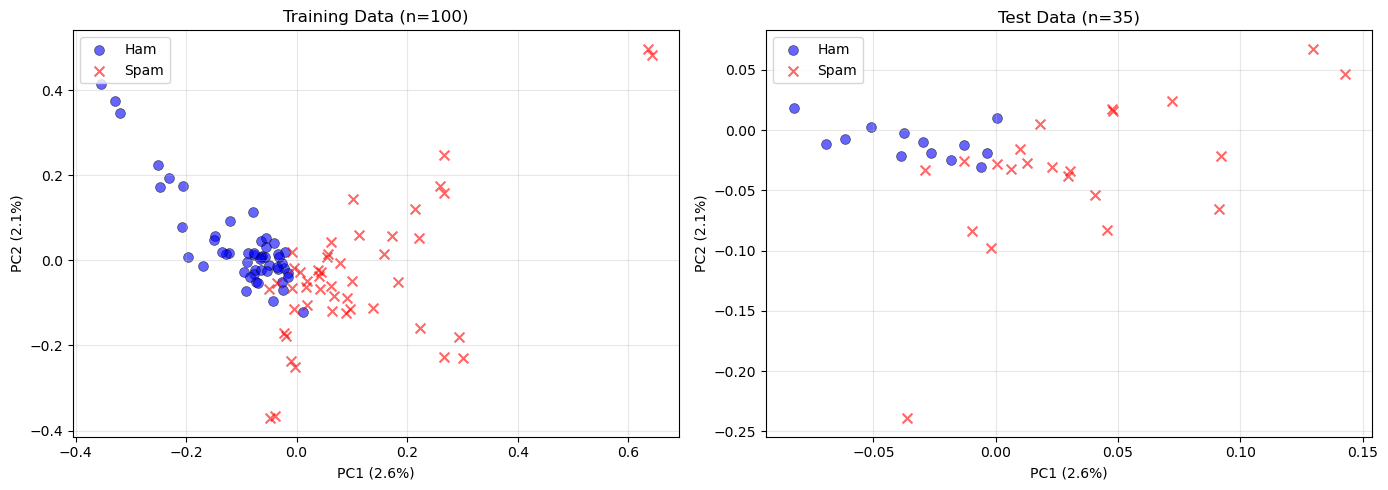

In [4]:
# Load data
X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf = load_npz("X_test_tfidf.npz")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print(f"Original train shape: {X_train_tfidf.shape}")
print(f"Original test shape: {X_test_tfidf.shape}")

# Subsample training data (for 100 samples)
n_train_samples = 100
idx_train = np.random.choice(len(y_train), min(n_train_samples, len(y_train)), replace=False)
X_train_sample = X_train_tfidf[idx_train]
y_train_sample = y_train[idx_train]

# Subsample test data (35 samples)
n_test_samples = 35
idx_test = np.random.choice(len(y_test), min(n_test_samples, len(y_test)), replace=False)
X_test_sample = X_test_tfidf[idx_test]
y_test_sample = y_test[idx_test]

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_sample.toarray())
X_test_pca = pca.transform(X_test_sample.toarray())

# Print variance info
var1, var2 = pca.explained_variance_ratio_
print(f"\nPC1: {var1*100:.2f}% | PC2: {var2*100:.2f}% | Total: {(var1+var2)*100:.2f}%")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training data
ax1.scatter(X_train_pca[y_train_sample==0, 0], X_train_pca[y_train_sample==0, 1], 
            c='blue', alpha=0.6, s=50, label='Ham', edgecolors='k', linewidth=0.5)
ax1.scatter(X_train_pca[y_train_sample==1, 0], X_train_pca[y_train_sample==1, 1], 
            c='red', marker='x', alpha=0.6, s=50, label='Spam', linewidth=1.5)
ax1.set_title(f'Training Data (n={n_train_samples})')
ax1.set_xlabel(f'PC1 ({var1*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({var2*100:.1f}%)')
ax1.legend()
ax1.grid(alpha=0.3)

# Test data
ax2.scatter(X_test_pca[y_test_sample==0, 0], X_test_pca[y_test_sample==0, 1], 
            c='blue', alpha=0.6, s=50, label='Ham', edgecolors='k', linewidth=0.5)
ax2.scatter(X_test_pca[y_test_sample==1, 0], X_test_pca[y_test_sample==1, 1], 
            c='red', marker='x', alpha=0.6, s=50, label='Spam', linewidth=1.5)
ax2.set_title(f'Test Data (n={n_test_samples})')
ax2.set_xlabel(f'PC1 ({var1*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({var2*100:.1f}%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_visualization_subsampled.png', dpi=300)
plt.show()


We can interpret that the information is lost while doing PCA = 2 components as Total variance explained is 4.74 % only.So, we can not completely rely on this PCA with 2 D. 

2D TSNE Visualization 

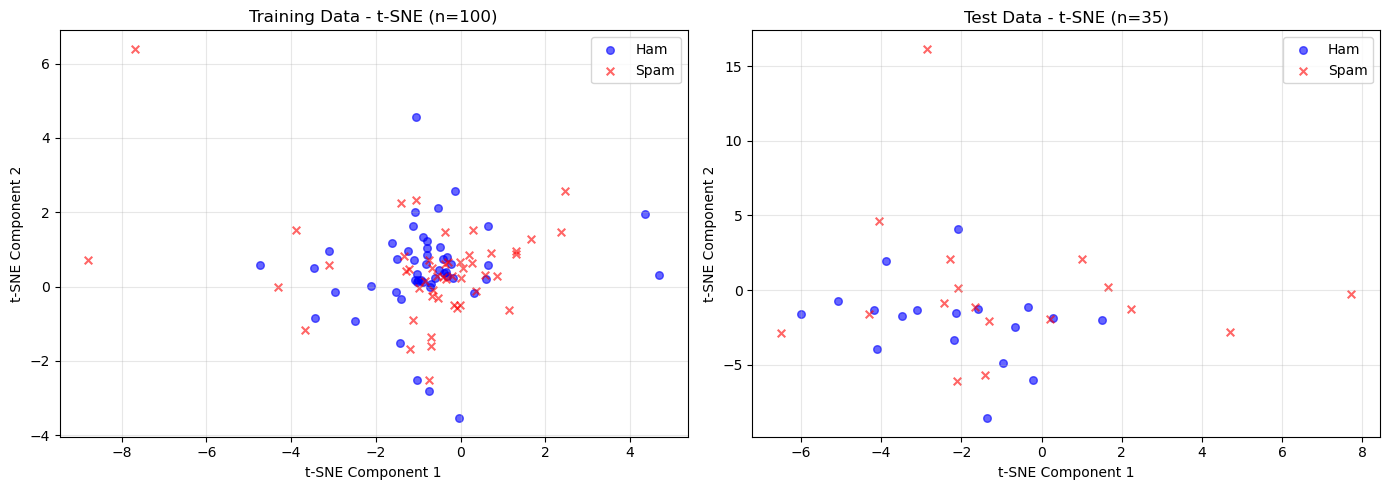

In [5]:
# Visualizing Enron spam data in 2D using t-SNE (100 training and 35 test samples)

n_samples_train = 100  
n_samples_test = 35

# training data
idx_train = np.random.choice(len(y_train), min(n_samples_train, len(y_train)), replace=False)
X_train_sample = X_train_tfidf[idx_train].toarray()
y_train_sample = y_train[idx_train]

# test data
idx_test = np.random.choice(len(y_test), min(n_samples_test, len(y_test)), replace=False)
X_test_sample = X_test_tfidf[idx_test].toarray()
y_test_sample = y_test[idx_test]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=250)
X_train_tsne = tsne.fit_transform(X_train_sample)

tsne_test = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=250)
X_test_tsne = tsne_test.fit_transform(X_test_sample)

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training data
ax1.scatter(X_train_tsne[y_train_sample==0, 0], X_train_tsne[y_train_sample==0, 1], 
            c='blue', alpha=0.6, s=30, label='Ham')
ax1.scatter(X_train_tsne[y_train_sample==1, 0], X_train_tsne[y_train_sample==1, 1], 
            c='red', marker='x', alpha=0.6, s=30, label='Spam')
ax1.set_title(f'Training Data - t-SNE (n={n_samples_train})')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.legend()
ax1.grid(alpha=0.3)

# Test data
ax2.scatter(X_test_tsne[y_test_sample==0, 0], X_test_tsne[y_test_sample==0, 1], 
            c='blue', alpha=0.6, s=30, label='Ham')
ax2.scatter(X_test_tsne[y_test_sample==1, 0], X_test_tsne[y_test_sample==1, 1], 
            c='red', marker='x', alpha=0.6, s=30, label='Spam')
ax2.set_title(f'Test Data - t-SNE (n={n_samples_test})')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300)
plt.show()


Using TSNE Visualization : TFIDF vectors for emails are overlapping in the 2 D dimensional feature space. 

Validation curve

[learning_curve] Training set sizes: [ 1344  2688  4032  5376  6720  8064  9408 10752 12096 13441]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.0min finished


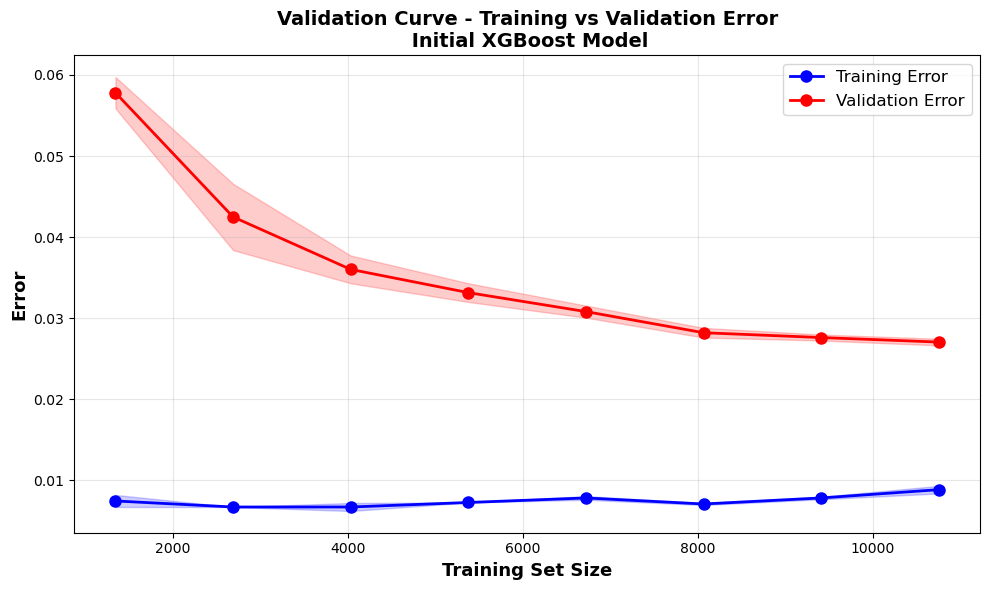

In [8]:
# Initial XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=SEED,
    n_jobs=-1
)

# Computation for learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train_tfidf,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Compute error (1 - accuracy)
train_error_mean = 1 - train_scores.mean(axis=1)
train_error_std = train_scores.std(axis=1)
val_error_mean = 1 - val_scores.mean(axis=1)
val_error_std = val_scores.std(axis=1)

# Validation Curve
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_error_mean, 'o-', color='blue', 
         label='Training Error', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_error_mean - train_error_std, 
                 train_error_mean + train_error_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_error_mean, 'o-', color='red', 
         label='Validation Error', linewidth=2, markersize=8)
plt.fill_between(train_sizes, val_error_mean - val_error_std, 
                 val_error_mean + val_error_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size', fontsize=13, fontweight='bold')
plt.ylabel('Error', fontsize=13, fontweight='bold')
plt.title('Validation Curve - Training vs Validation Error\n Initial XGBoost Model', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Validation_curve_error.png', dpi=300)
plt.show()


# It is observed that the validation error is also decreasing with increase in the training set size, this indicates the model is well fit with the enron dataset. 

### *K*-fold cross-validation to *estimate* held-out performance

In [36]:
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")

# Training an XGBoost classifier with initial hyperparameters
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=SEED,
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

# Computing Training & testing accuracy
train_acc = accuracy_score(y_train, model.predict(X_train_tfidf))
test_acc = accuracy_score(y_test, model.predict(X_test_tfidf))

print(f"Training accuracy:           {train_acc*100:.1f}%")
print(f"Held-out accuracy (testing): {test_acc*100:.1f}%")

# K-fold Cross-Validation (K from 2 to 3)

for K in range(2, 4):
        
    cv_scores = cross_val_score(
        model, 
        X_train_tfidf, 
        y_train, 
        cv=K,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    print(f"held-out accuracy ({K}-fold):   {mean_score*100:.1f}% (±{std_score*100:.1f}%)")
    


Train shape: (26882, 5000)
Test shape: (6721, 5000)
Training accuracy:           98.9%
Held-out accuracy (testing): 98.0%
held-out accuracy (2-fold):   97.6% (±0.0%)
held-out accuracy (3-fold):   97.8% (±0.2%)


# Hyperparameter search

# Randomized search for hyperparameter tuning of XGBoost

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'learning_rate': 0.29106359131330695, 'max_depth': 7, 'n_estimators': 120}
Best CV ROC-AUC: 0.9980

Test Accuracy : 98.17%
Test Precision: 97.26%
Test Recall   : 99.21%
Test F1-Score : 98.23%
Test ROC-AUC  : 99.78%

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      3288
        Spam       0.97      0.99      0.98      3433

    accuracy                           0.98      6721
   macro avg       0.98      0.98      0.98      6721
weighted avg       0.98      0.98      0.98      6721



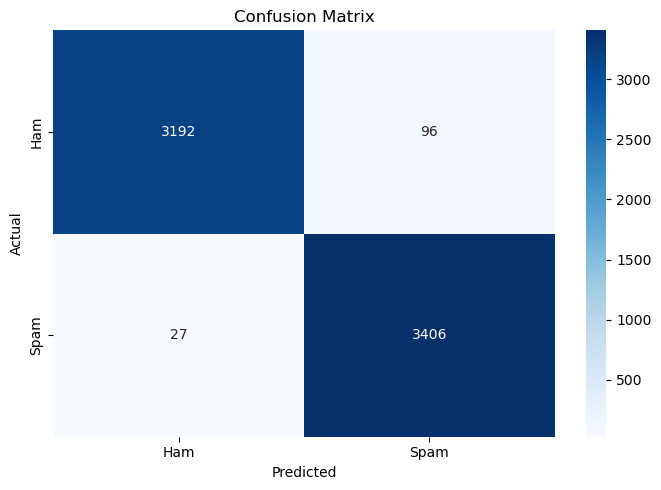


TN=3192, FP=96, FN=27, TP=3406
Model saved as 'best_xgb_model.pkl'


In [38]:
# Hyperparameter search
param_distributions = {
    'learning_rate': reciprocal(0.01, 1.0),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 300)
}

random_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                  tree_method='hist', random_state=SEED),
    param_distributions,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    random_state=SEED,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"\nBest Parameters: {best_params}")
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")

# Evaluating on test set
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test_tfidf)
y_test_proba = best_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation Metrics
print(f"\nTest Accuracy : {accuracy_score(y_test, y_test_pred)*100:.2f}%")
print(f"Test Precision: {precision_score(y_test, y_test_pred)*100:.2f}%")
print(f"Test Recall   : {recall_score(y_test, y_test_pred)*100:.2f}%")
print(f"Test F1-Score : {f1_score(y_test, y_test_pred)*100:.2f}%")
print(f"Test ROC-AUC  : {roc_auc_score(y_test, y_test_proba)*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Ham', 'Spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Save the best model Using pickle

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved as 'best_xgb_model.pkl'")




# With hyperparameter tuning: Confusion matrix is improved a little bit with misclassifications as 27 plus 96 , instead of that in initial model : 27 and 106 respectively.But, still we have large mis-classifications.  

# Evaluate on similar pairs of email dataset  

Model loaded from 'best_xgb_model.pkl'
Total emails: 20
Accuracy: 75.00%
Correct predictions: 15/20


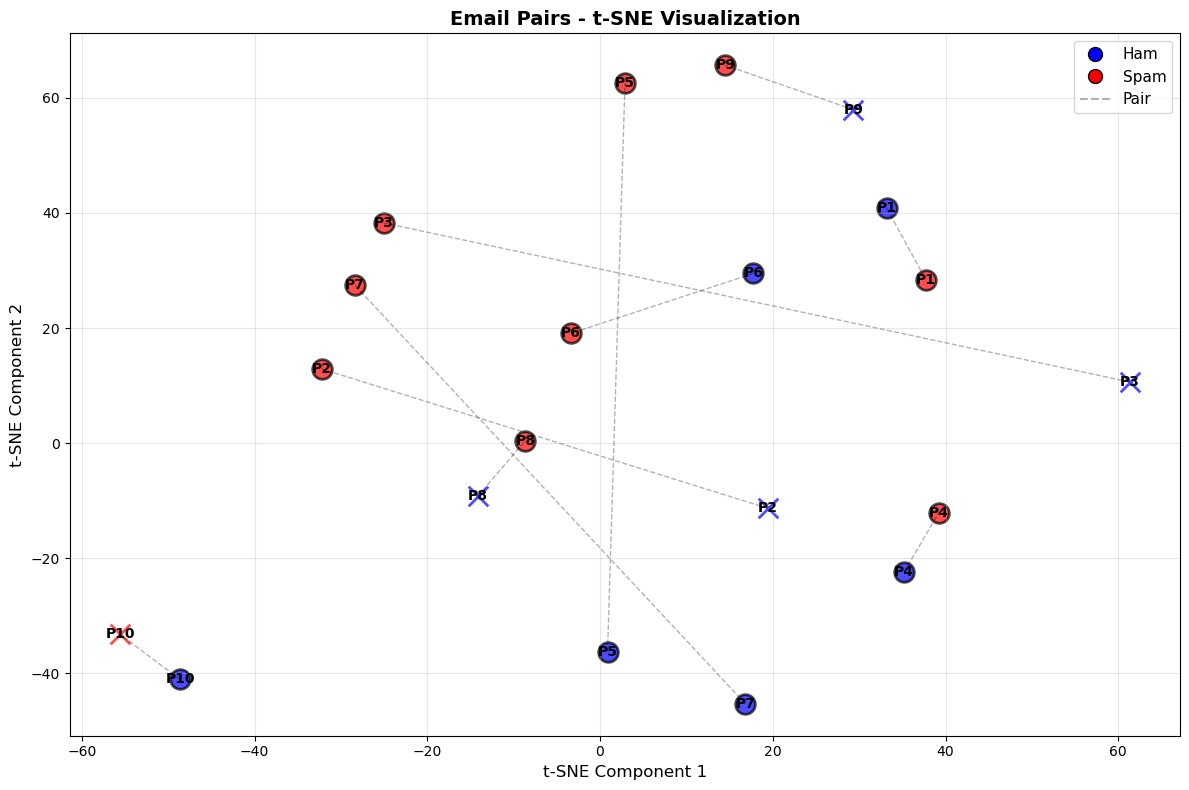


Prediction Results for All Email Pairs:
 Pair Type                                         Email_Preview True_Label Predicted  Confidence Correct
    1  Ham Meeting scheduled for tomorrow at 3pm in conferenc...        Ham       Ham   94.434100       ✓
    1 Spam MEETING CONFIRMED! Click here NOW to claim your sp...       Spam      Spam   68.083328       ✓
    2  Ham Your account statement is ready for review. Please...        Ham      Spam   89.222497       ✗
    2 Spam Your account has WON $50,000! Click here immediate...       Spam      Spam   98.877841       ✓
    3  Ham Thank you for your purchase. Your order will be sh...        Ham      Spam   75.359750       ✗
    3 Spam Congratulations! You've been selected for FREE pro...       Spam      Spam   96.422410       ✓
    4  Ham Please review the attached document and provide fe...        Ham       Ham   94.327307       ✓
    4 Spam URGENT! Review this document to claim your inherit...       Spam      Spam   87.025672       ✓
    5

In [39]:
with open('best_xgb_model.pkl', 'rb') as f:
    best_model = pickle.load(f)
    print("Model loaded from 'best_xgb_model.pkl'")
   
# Similar Email pairs
email_pairs = [
    {
        'ham': "Meeting scheduled for tomorrow at 3pm in conference room to discuss quarterly results",
        'spam': "MEETING CONFIRMED! Click here NOW to claim your spot and WIN prizes at 3pm tomorrow!"
    },
    {
        'ham': "Your account statement is ready for review. Please log in to view your balance.",
        'spam': "Your account has WON $50,000! Click here immediately to claim your prize money!"
    },
    {
        'ham': "Thank you for your purchase. Your order will be shipped within 2 business days.",
        'spam': "Congratulations! You've been selected for FREE products! Act now, limited time offer!"
    },
    {
        'ham': "Please review the attached document and provide feedback by end of week.",
        'spam': "URGENT! Review this document to claim your inheritance of $5 MILLION dollars!"
    },
    {
        'ham': "Reminder: Project deadline is next Friday. Please submit your reports.",
        'spam': "REMINDER: You have unclaimed rewards! Submit your credit card details NOW!"
    },
    {
        'ham': "Can you send me the presentation slides from yesterday's meeting? Thanks.",
        'spam': "SEND ME YOUR BANK DETAILS NOW to receive your lottery winnings! ACT FAST!"
    },
    {
        'ham': "Let's schedule a call next week to discuss the contract terms and pricing.",
        'spam': "CALL NOW to claim your FREE VACATION! Limited spots available, ACT IMMEDIATELY!"
    },
    {
        'ham': "The quarterly report shows steady growth in all departments this year.",
        'spam': "SHOCKING GROWTH in your bank account! Click to see how you WON millions!"
    },
    {
        'ham': "Please confirm your attendance at the conference by replying to this email.",
        'spam': "CONFIRM YOUR EMAIL to unlock FREE MONEY! Reply now with your credit card!"
    },
    {
        'ham': "Your password has been successfully updated. Contact support if you need help.",
        'spam': "YOUR PASSWORD EXPIRED! Update NOW by entering your banking details here!"
    }
]

# Prepare data
emails = []
labels = []
for pair in email_pairs:
    emails.append(pair['ham'])
    labels.append(0)
    emails.append(pair['spam'])
    labels.append(1)

emails = np.array(emails)
labels = np.array(labels)

print(f"Total emails: {len(emails)}")

# Loading vectorizer and transform emails
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

emails_tfidf = tfidf.transform(emails)

# Getting predictions
predictions = best_model.predict(emails_tfidf)
correct_predictions = (predictions == labels)
print(f"Accuracy: {sum(correct_predictions)/len(predictions)*100:.2f}%")
print(f"Correct predictions: {sum(correct_predictions)}/{len(predictions)}")
probabilities = best_model.predict_proba(emails_tfidf)  # probability scores

# Apply t-SNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42, max_iter=1000)
emails_tsne = tsne.fit_transform(emails_tfidf.toarray()) # "".to array" will make it dense

# Plots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each pair
for pair_id in range(len(email_pairs)):
    ham_idx = pair_id * 2
    spam_idx = pair_id * 2 + 1
    
    ham_x, ham_y = emails_tsne[ham_idx]
    spam_x, spam_y = emails_tsne[spam_idx]
    
    # Connect pairs with line
    ax.plot([ham_x, spam_x], [ham_y, spam_y], 'k--', alpha=0.3, linewidth=1)
    
    # Plot ham (blue circle)
    marker = 'o' if correct[ham_idx] else 'x'
    ax.scatter(ham_x, ham_y, c='blue', marker=marker, s=200, 
               alpha=0.7, edgecolors='k', linewidth=2)
    
    # Plot spam (red circle)
    marker = 'o' if correct[spam_idx] else 'x'
    ax.scatter(spam_x, spam_y, c='red', marker=marker, s=200, 
               alpha=0.7, edgecolors='k', linewidth=2)
    
    # Label pairs
    ax.text(ham_x, ham_y, f'P{pair_id+1}', ha='center', va='center', 
            fontsize=10, fontweight='bold')
    ax.text(spam_x, spam_y, f'P{pair_id+1}', ha='center', va='center', 
            fontsize=10, fontweight='bold')

# Legend
from matplotlib.lines import Line2D
legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
           markersize=10, label='Ham', markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, label='Spam', markeredgecolor='k'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.3, label='Pair')
]

ax.legend(handles=legend, fontsize=11)
ax.set_xlabel('t-SNE Component 1', fontsize=12)
ax.set_ylabel('t-SNE Component 2', fontsize=12)
ax.set_title('Email Pairs - t-SNE Visualization', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('email_pairs_tsne.png', dpi=300)
plt.show()

# Detailed Analysis Table

analysis_data = []
for i, pair in enumerate(email_pairs):
    ham_idx = i * 2
    spam_idx = i * 2 + 1
    
    analysis_data.append({
        'Pair': i + 1,
        'Type': 'Ham',
        'Email_Preview': pair['ham'][:50] + '...',
        'True_Label': 'Ham',
        'Predicted': 'Ham' if predictions[ham_idx] == 0 else 'Spam',
        'Confidence': probabilities[ham_idx][predictions[ham_idx]] * 100,
        'Correct': '✓' if correct_predictions[ham_idx] else '✗'
    })
    
    analysis_data.append({
        'Pair': i + 1,
        'Type': 'Spam',
        'Email_Preview': pair['spam'][:50] + '...',
        'True_Label': 'Spam',
        'Predicted': 'Ham' if predictions[spam_idx] == 0 else 'Spam',
        'Confidence': probabilities[spam_idx][predictions[spam_idx]] * 100,
        'Correct': '✓' if correct_predictions[spam_idx] else '✗'
    })

analysis_df = pd.DataFrame(analysis_data)
print("\nPrediction Results for All Email Pairs:")
print(analysis_df.to_string(index=False))


# It is observed that the distance between vectors of similar Emails in pairs such as 8, 9 and 10 is very less respectively, and the model made mis-classification for ham vs spam prediction. This classifier is not able to learn the contextual meanings of similar emails and just learn the words only in the emails. That is the area of concern.  